Useful links

https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import partial

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/posital-2-braccio/Posital 2 braccio.trc
/kaggle/input/gru-dpx-posital-1-braccio-training/Gru_DPX_Posital_1_braccio_Training.trc


In [77]:
# adjust these parameters

# data collection
# fname = "../input/posital-2-braccio/Posital 2 braccio.trc"
fname = "../input/gru-dpx-posital-1-braccio-training/Gru_DPX_Posital_1_braccio_Training.trc"
rows_to_skip = 20

# data filter
command_rolling_length = 1
position_rolling_length = 1
velocity_rolling_length = 1

# keras model
labels_column_names = ['DV2']
output_dimension = len(labels_column_names)
model_filename= './model_1'

In [78]:
# utility function: convert hex string to unsigned int (es. FF00 -> 65280)
def hex2int_unsigned(hex_val):
    return int(hex_val,16)

In [79]:
# utility function: convert hex string to signed int (es. FF00 -> -256)
def hex2int_signed(hexval):
    bits = 16
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val

In [90]:
# read text file into pandas DataFrame
df = pd.read_csv(
        fname,
        delim_whitespace=True, 
        skiprows = rows_to_skip, 
        header=None, 
        names=["N","O","T","B","I","d","R","L","D0","D1","D2","D3","D4","D5","D6","D7"],
        nrows=50000,
        index_col = 'O',
        converters={
            'O': partial(pd.to_datetime,unit='ms',infer_datetime_format=True)
            #    'D0': partial(int, base=16),
        }
        
    )

# display DataFrame
df

,N,T,B,I,d,R,L,D0,D1,D2,D3,D4,D5,D6,D7
O,,,,,,,,,,,,,,,
1970-01-01 00:00:00.003144,5,DT,1,03C4,Rx,-,8,8B,01,0F,03,2D,00,E8,01
1970-01-01 00:00:00.003384,6,DT,1,01C4,Rx,-,8,C9,02,AE,04,00,00,60,02
1970-01-01 00:00:00.010140,7,DT,1,0181,Rx,-,4,13,CD,DB,D3,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.011217,8,DT,1,0281,Rx,-,8,13,CD,FF,FF,DB,D3,FE,FF
1970-01-01 00:00:00.012237,9,DT,1,0182,Rx,-,8,6B,1B,00,01,C3,03,DB,FF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:12.986808,50000,DT,1,0181,Rx,-,4,FE,F3,0B,B3,NaN,NaN,NaN,NaN
1970-01-01 00:01:12.987882,50001,DT,1,0281,Rx,-,8,FE,F3,FF,FF,0B,B3,FE,FF
1970-01-01 00:01:12.990346,50002,DT,1,0182,Rx,-,8,BC,16,3A,00,45,04,C7,FF


In [45]:
# start_time = pd.to_datetime('26/05/2022 12:09:59.00')    
# converters = {'O': lambda x: pd.to_datetime(float(x), unit='ms', origin = start_time)}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<AxesSubplot:xlabel='O'>

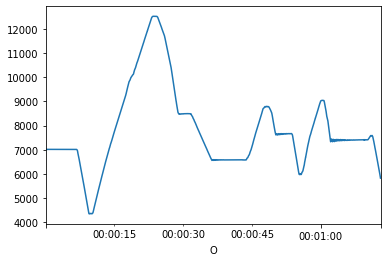

In [91]:
# select posital rows
posital = df[df["I"] == '0182']

# convert angle from hex bytes to unsigned int
posital['P2'] = (posital['D1'] + posital['D0']).apply(hex2int_unsigned)

# resample at 10 milliseconds
posital = posital.resample("10L").ffill()

posital['P2'].plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<AxesSubplot:xlabel='O'>

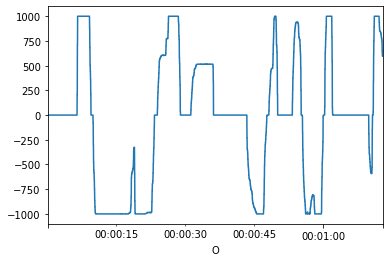

In [92]:
# select joystick rows
# command = df[df["I"] == '02B2']
command = df[df["I"] == '02B1']

# convert set points from hex strings to signed int
command['C2'] = (command['D1'] + command['D0']).apply(hex2int_signed)
command['C1'] = (command['D3'] + command['D2']).apply(hex2int_signed)

# resample at 10 milliseconds
command = command.resample("10L").ffill()

command['C1'].plot()

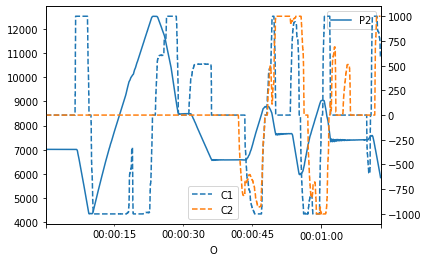

In [93]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

posital.plot(y=['P2'], ax=ax)
command.plot(y=["C1", "C2"], ax=ax2, ls="--")

plt.show()

In [94]:
min_length = min(command.shape[0], posital.shape[0])
min_length

7294

<AxesSubplot:xlabel='O'>

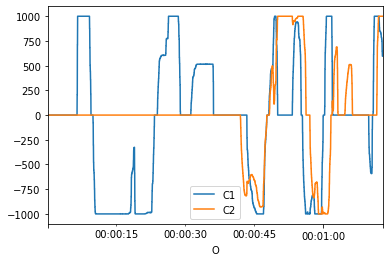

In [95]:
command = command[['C1','C2']].iloc[0:min_length].copy()
command = command.rolling(command_rolling_length).mean()
command.plot()

<AxesSubplot:xlabel='O'>

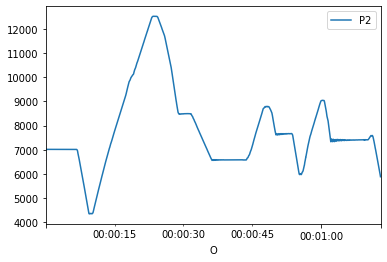

In [96]:
position = posital[['P2']].iloc[0:min_length].copy()

position = position.rolling(position_rolling_length).mean()
position.plot()

In [97]:
df2 = pd.merge(command, position, left_index=True, right_index=True)
df2

,C1,C2,P2
O,,,
1970-01-01 00:00:00.030,NaN,NaN,7019.0
1970-01-01 00:00:00.040,0.0,0.0,7019.0
1970-01-01 00:00:00.050,0.0,0.0,7019.0
1970-01-01 00:00:00.060,0.0,0.0,7019.0
1970-01-01 00:00:00.070,0.0,0.0,7019.0
...,...,...,...
1970-01-01 00:01:12.900,648.0,1000.0,5936.0
1970-01-01 00:01:12.910,648.0,1000.0,5924.0
1970-01-01 00:01:12.920,596.0,1000.0,5901.0


<AxesSubplot:xlabel='O'>

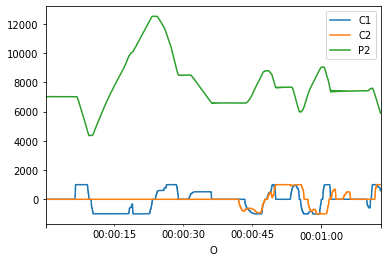

In [98]:
df2 = df2.dropna()
df2.plot()

In [99]:
df2.describe()

,C1,C2,P2
count,7291.000000,7291.000000,7291.000000
mean,-73.814977,18.019476,7834.831710
std,649.091165,436.226404,1696.034806
min,-1000.000000,-1000.000000,4354.000000
25%,-773.500000,0.000000,6798.000000
50%,0.000000,0.000000,7411.000000
75%,430.000000,0.000000,8490.000000
max,1000.000000,1000.000000,12515.000000


In [55]:
df2.to_excel('df2.xlsx')

# Create additional columns

In [100]:
df3 = df2.copy()

In [57]:
df3

,C1,C2,P2
O,,,
1970-01-01 00:00:00.020,0.0,0.0,3369.0
1970-01-01 00:00:00.030,0.0,0.0,3371.0
1970-01-01 00:00:00.040,0.0,0.0,3374.0
1970-01-01 00:00:00.050,0.0,0.0,3377.0
1970-01-01 00:00:00.060,0.0,0.0,3380.0
...,...,...,...
1970-01-01 00:01:02.020,0.0,0.0,6523.0
1970-01-01 00:01:02.030,0.0,0.0,6523.0
1970-01-01 00:01:02.040,0.0,0.0,6523.0


In [101]:
C1_BASE = 3  # start from columns 3
C1_STEP = 3  # take 3 steps back
C1_SIZE = 33 # was 33 in the ETH model

C2_BASE = C1_BASE+C1_SIZE  # start from columns 3+5
C2_STEP = 3  # take 3 steps back
C2_SIZE = 33 # was 33 in the ETH model


V_BASE = C1_BASE+C1_SIZE+C2_SIZE 
V_STEP = 1 # take 1 step back
V_SIZE = 10 # was 10 in the ETH model

# create columns with past commands
for i in range(1,C1_SIZE+1):
    df3[C1_BASE+i] = df3['C1'].shift(i*C1_STEP)
    df3.rename(columns={C1_BASE+i:'C1-'+ str(i*C1_STEP)}, inplace=True)

for i in range(1,C2_SIZE+1):
    df3[C2_BASE+i] = df3['C2'].shift(i*C2_STEP)
    df3.rename(columns={C2_BASE+i:'C2-'+ str(i*C2_STEP)}, inplace=True)

# create velocities from positions
df3['V2'] = df3['P2']-df3['P2'].shift(1)

# filter velocities
df3['V2'] = df3['V2'].rolling(velocity_rolling_length).mean()

# create delta velocities from velocities
df3['DV2'] = df3['V2']-df3['V2'].shift(1)

# create columns with past velocities
for i in range(1,V_SIZE+1):
    df3[V_BASE+i] = df3['V2'].shift(i*V_STEP)
    df3.rename(columns={V_BASE+i:'V2-'+ str(i*V_STEP)}, inplace=True)


In [102]:
df3 = df3.fillna(0)
df3

,C1,C2,P2,C1-3,C1-6,C1-9,C1-12,C1-15,C1-18,C1-21,...,V2-1,V2-2,V2-3,V2-4,V2-5,V2-6,V2-7,V2-8,V2-9,V2-10
O,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.040,0.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.050,0.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.060,0.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.070,0.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.080,0.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:12.900,648.0,1000.0,5936.0,648.0,746.0,767.0,767.0,784.0,784.0,792.0,...,-23.0,-12.0,-11.0,-12.0,-11.0,-12.0,-11.0,-11.0,-11.0,-11.0
1970-01-01 00:01:12.910,648.0,1000.0,5924.0,648.0,746.0,746.0,767.0,784.0,784.0,792.0,...,0.0,-23.0,-12.0,-11.0,-12.0,-11.0,-12.0,-11.0,-11.0,-11.0
1970-01-01 00:01:12.920,596.0,1000.0,5901.0,648.0,746.0,746.0,767.0,767.0,784.0,792.0,...,-12.0,0.0,-23.0,-12.0,-11.0,-12.0,-11.0,-12.0,-11.0,-11.0


# Use KERAS

In [103]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.4


In [104]:
keras_dataset=df3.copy()

In [105]:
# split dataset in train and test
train_dataset = keras_dataset.sample(frac=0.8, random_state=0)
test_dataset = keras_dataset.drop(train_dataset.index)

# extract features and labels into separate arrays
train_features = train_dataset.copy()
train_features = train_features.drop(labels_column_names, axis=1)
train_labels = train_dataset.loc[:, labels_column_names]

test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

In [106]:
train_features

,C1,C2,P2,C1-3,C1-6,C1-9,C1-12,C1-15,C1-18,C1-21,...,V2-1,V2-2,V2-3,V2-4,V2-5,V2-6,V2-7,V2-8,V2-9,V2-10
O,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:47.250,-509.0,-456.0,8604.0,-649.0,-649.0,-798.0,-924.0,-924.0,-947.0,-947.0,...,7.0,8.0,7.0,6.0,7.0,7.0,7.0,7.0,6.0,7.0
1970-01-01 00:00:44.510,-775.0,-602.0,6875.0,-775.0,-766.0,-763.0,-763.0,-759.0,-759.0,-750.0,...,7.0,7.0,10.0,3.0,10.0,3.0,6.0,5.0,6.0,4.0
1970-01-01 00:00:08.350,1000.0,0.0,5524.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,-16.0,-10.0,-11.0,-10.0,-5.0,-17.0,-10.0,-11.0,-5.0,-11.0
1970-01-01 00:00:06.450,207.0,0.0,7019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:20.430,-1000.0,0.0,10891.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:12.710,792.0,1000.0,6147.0,792.0,818.0,818.0,832.0,838.0,838.0,843.0,...,-10.0,-11.0,-10.0,-11.0,-10.0,-11.0,-11.0,-10.0,-11.0,-10.0
1970-01-01 00:01:03.670,0.0,0.0,7373.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.0,-2.0,-4.0,-1.0,-5.0,-9.0,-3.0,-7.0,-4.0,-5.0
1970-01-01 00:00:02.430,0.0,0.0,7018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


## Normalization

In [107]:
# show train_dataset mean and std
train_dataset.describe().transpose()

# create a Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)  # many variables
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) #one variable

# set mean and std for Normalization layer
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[-7.99024658e+01  1.51951094e+01  7.82728613e+03 -8.01031799e+01
  -7.99993362e+01 -8.03058395e+01 -8.03080750e+01 -8.08751984e+01
  -8.11932373e+01 -8.15374603e+01 -8.20798721e+01 -8.20008469e+01
  -8.20203857e+01 -8.20554199e+01 -8.21546097e+01 -8.25614548e+01
  -8.26087799e+01 -8.32895584e+01 -8.34294510e+01 -8.38266449e+01
  -8.39009857e+01 -8.37843475e+01 -8.39072113e+01 -8.38328781e+01
  -8.38942184e+01 -8.41643677e+01 -8.44289322e+01 -8.49667587e+01
  -8.54375153e+01 -8.61193390e+01 -8.65434570e+01 -8.70442581e+01
  -8.73551102e+01 -8.74686890e+01 -8.76686325e+01 -8.79785385e+01
   1.48686743e+01  1.45168934e+01  1.41256657e+01  1.38671360e+01
   1.34755745e+01  1.30291386e+01  1.27783270e+01  1.24505472e+01
   1.20876055e+01  1.16720390e+01  1.13331099e+01  1.09031410e+01
   1.04832869e+01  1.02465267e+01  9.79118729e+00  9.37459469e+00
   9.07217789e+00  8.58391571e+00  8.36241913e+00  7.86011076e+00
   7.49323225e+00  7.19766903e+00  6.74233055e+00  6.45671225e+00
   6.02091

## Utility functions

In [108]:
def plot_loss(history, ymax=100):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)

## Regression using a DNN

In [109]:
# create keras model

dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(units=128, activation='relu'),
      layers.Dense(units = 128, activation='relu'),
      layers.Dense(units=128, activation='relu'),
      layers.Dense(output_dimension)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 80)                161       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               10368     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 43,682
Trainable params: 43,521
Non-trainable params: 161
_________________________________________________________________


In [110]:
# train keras model

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10
)

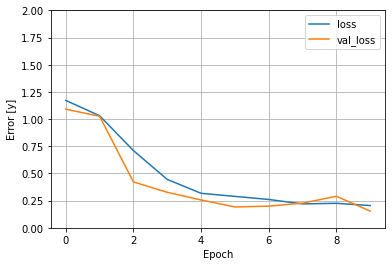

In [111]:
plot_loss(history,2)

## Evaluate model with test_data

In [112]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.1605628877878189

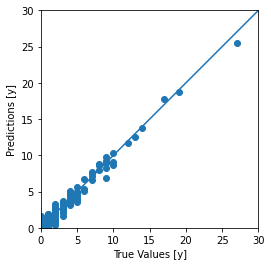

In [70]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
lims = [0, 30]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [113]:
# evaluate predictions error
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [y]')
_ = plt.ylabel('Count')

ValueError: Unable to coerce to DataFrame, shape must be (1458, 1): given (1241, 1)

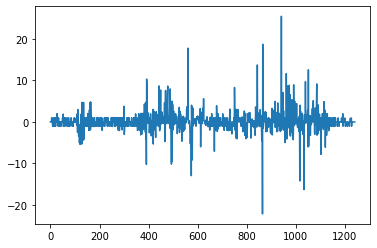

In [114]:
plt.plot(test_predictions)

<AxesSubplot:xlabel='O'>

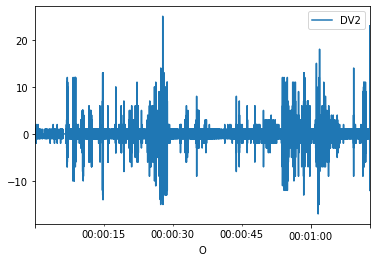

In [115]:
df3[labels_column_names].plot()

## Save and Load model

In [74]:
dnn_model.save(model_filename)

2022-10-11 10:08:05.770888: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [75]:
reloaded = tf.keras.models.load_model(model_filename)